In [38]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers

In [39]:
gdf = gpd.read_file("/Users/ehast/Desktop/cleaned florida data")

In [40]:
# Names were truncated during exporting. Need to rename them to original names.
# Define a dictionary mapping current column names to desired column names
column_mapping = {
    "NAME": "NAME",
    "LEVEL1_LAN": "LEVEL1_LAN",
    "LEVEL1_L_1": "LEVEL1_L_1",
    "POP2010": "POP2010",
    "geometry": "geometry",
    "AVG ELEVAT": "AVG ELEVATION",
    "elevation_": "elevation_post_rise",
    "POP2150": "POP2150",
    "Income/yea": "Income/year",
    "elevatio_1": "elevation_category",
    "pop_catego": "pop_category",
    "income_cat": "income_category"
}

# Rename the columns
gdf.rename(columns=column_mapping, inplace=True)

In [41]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429635 entries, 0 to 1429634
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   NAME                 1426588 non-null  object  
 1   LEVEL1_LAN           1429635 non-null  int64   
 2   LEVEL1_L_1           1429635 non-null  object  
 3   POP2010              1426588 non-null  float64 
 4   AVG ELEVATION        1426588 non-null  float64 
 5   elevation_post_rise  1426588 non-null  float64 
 6   POP2150              1426588 non-null  float64 
 7   Income/year          1426588 non-null  object  
 8   elevation_category   1426588 non-null  float64 
 9   pop_category         1426588 non-null  float64 
 10  income_category      1426588 non-null  float64 
 11  geometry             1429635 non-null  geometry
dtypes: float64(7), geometry(1), int64(1), object(3)
memory usage: 130.9+ MB


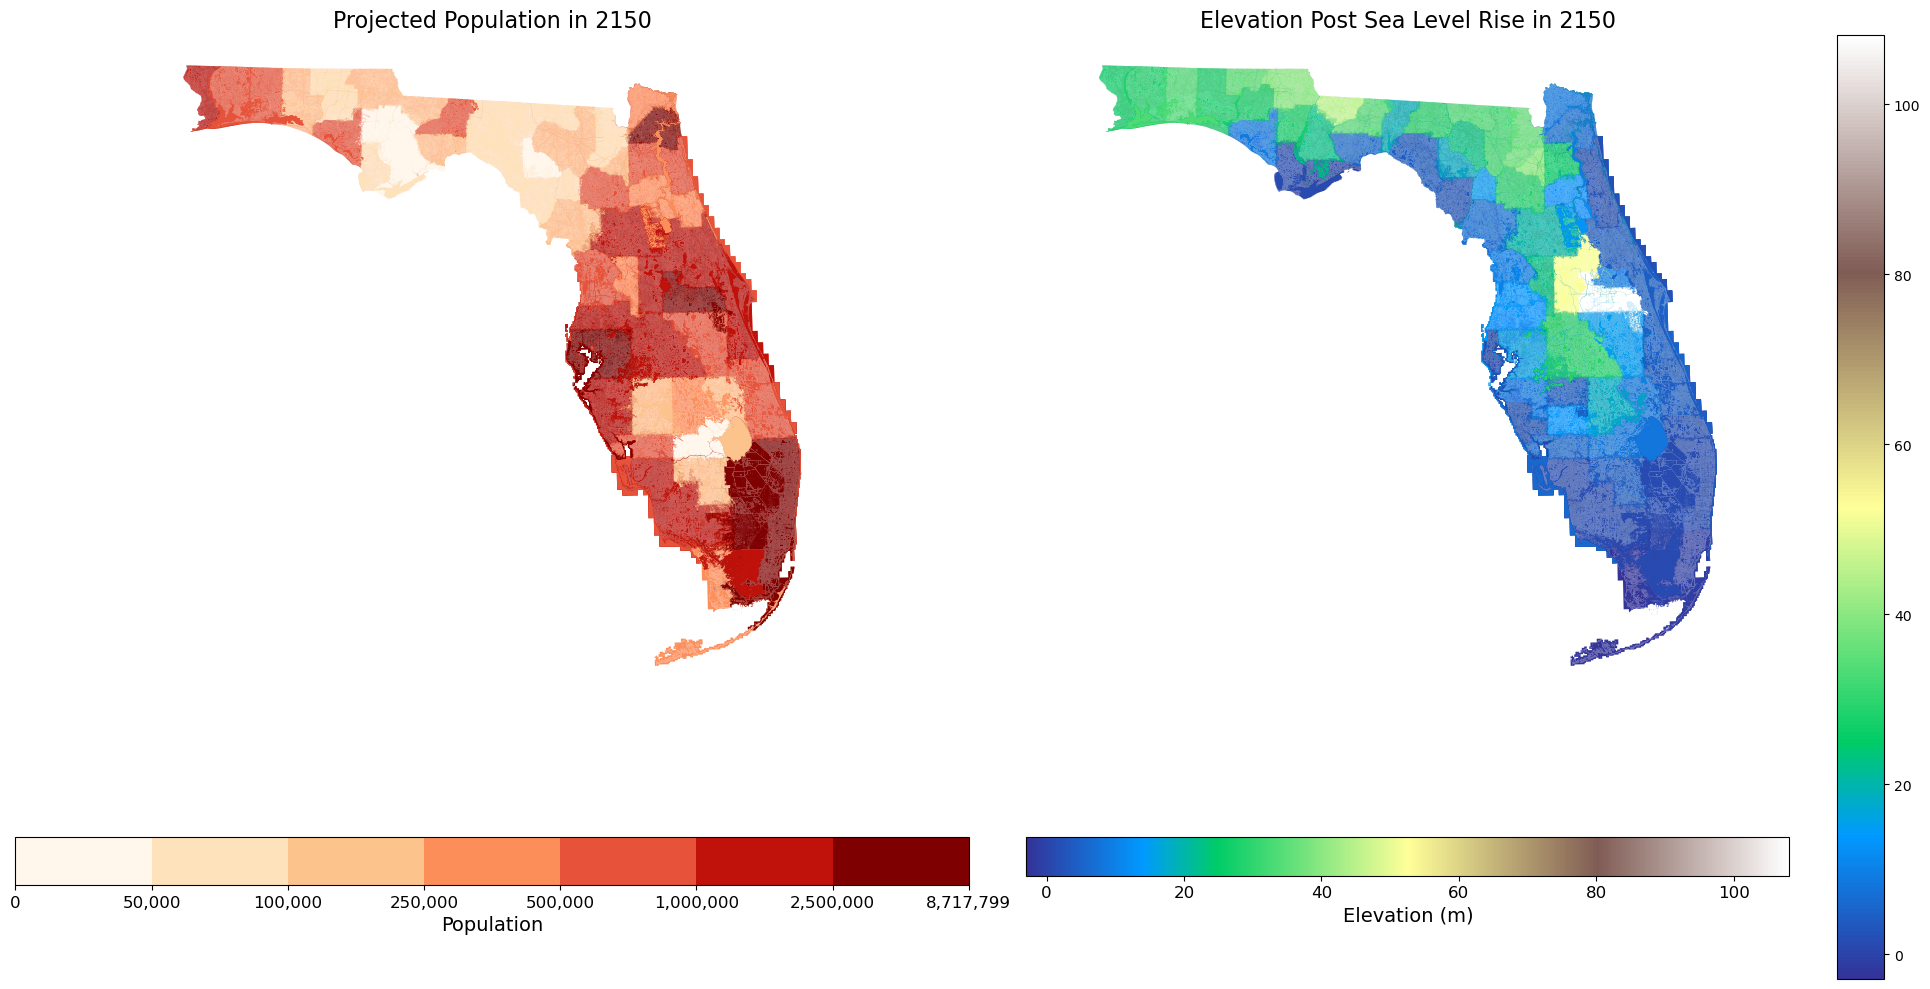

In [42]:
# Define the custom bins and their labels for the colorbar
bins = [0, 50000, 100000, 250000, 500000, 1000000, 2500000, gdf['POP2150'].max()]
bin_labels = [f"{int(b):,}" for b in bins]

fig, ax = plt.subplots(1, 2, figsize=(20,10))

# For Population
cmap = plt.cm.OrRd
norm = mcolors.BoundaryNorm(bins, cmap.N)
pop_plot = gdf.plot(column='POP2150', ax=ax[0], cmap=cmap, legend=False, norm=norm)
ax[0].set_title('Projected Population in 2150', fontsize=16)
ax[0].axis('off')
# Create a custom colorbar for Population
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=bins, ax=ax[0], orientation='horizontal')
cbar.set_label('Population', fontsize=14)
cbar.ax.set_xticklabels(bin_labels, fontsize=12)

# For Elevation Post Sea Level Rise in 2150
elev_plot = gdf.plot(column='elevation_post_rise', ax=ax[1], legend=True, cmap='terrain')
ax[1].set_title('Elevation Post Sea Level Rise in 2150', fontsize=16)
ax[1].axis('off')
# Adjust colorbar size and label
elev_cbar = ax[1].get_figure().colorbar(elev_plot.collections[0], ax=ax[1], orientation='horizontal')
elev_cbar.set_label('Elevation (m)', fontsize=14)
elev_cbar.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

In [43]:
# Didn't realize the income/year was object type, need to fix.
# Convert 'Income/year' column to numeric
gdf['Income/year'] = gdf['Income/year'].astype(float)
gdf['Income/year']

0          47341.0
1          47341.0
2          47341.0
3          47341.0
4          47341.0
            ...   
1429630    49463.0
1429631    49463.0
1429632    49463.0
1429633    49463.0
1429634    49463.0
Name: Income/year, Length: 1429635, dtype: float64

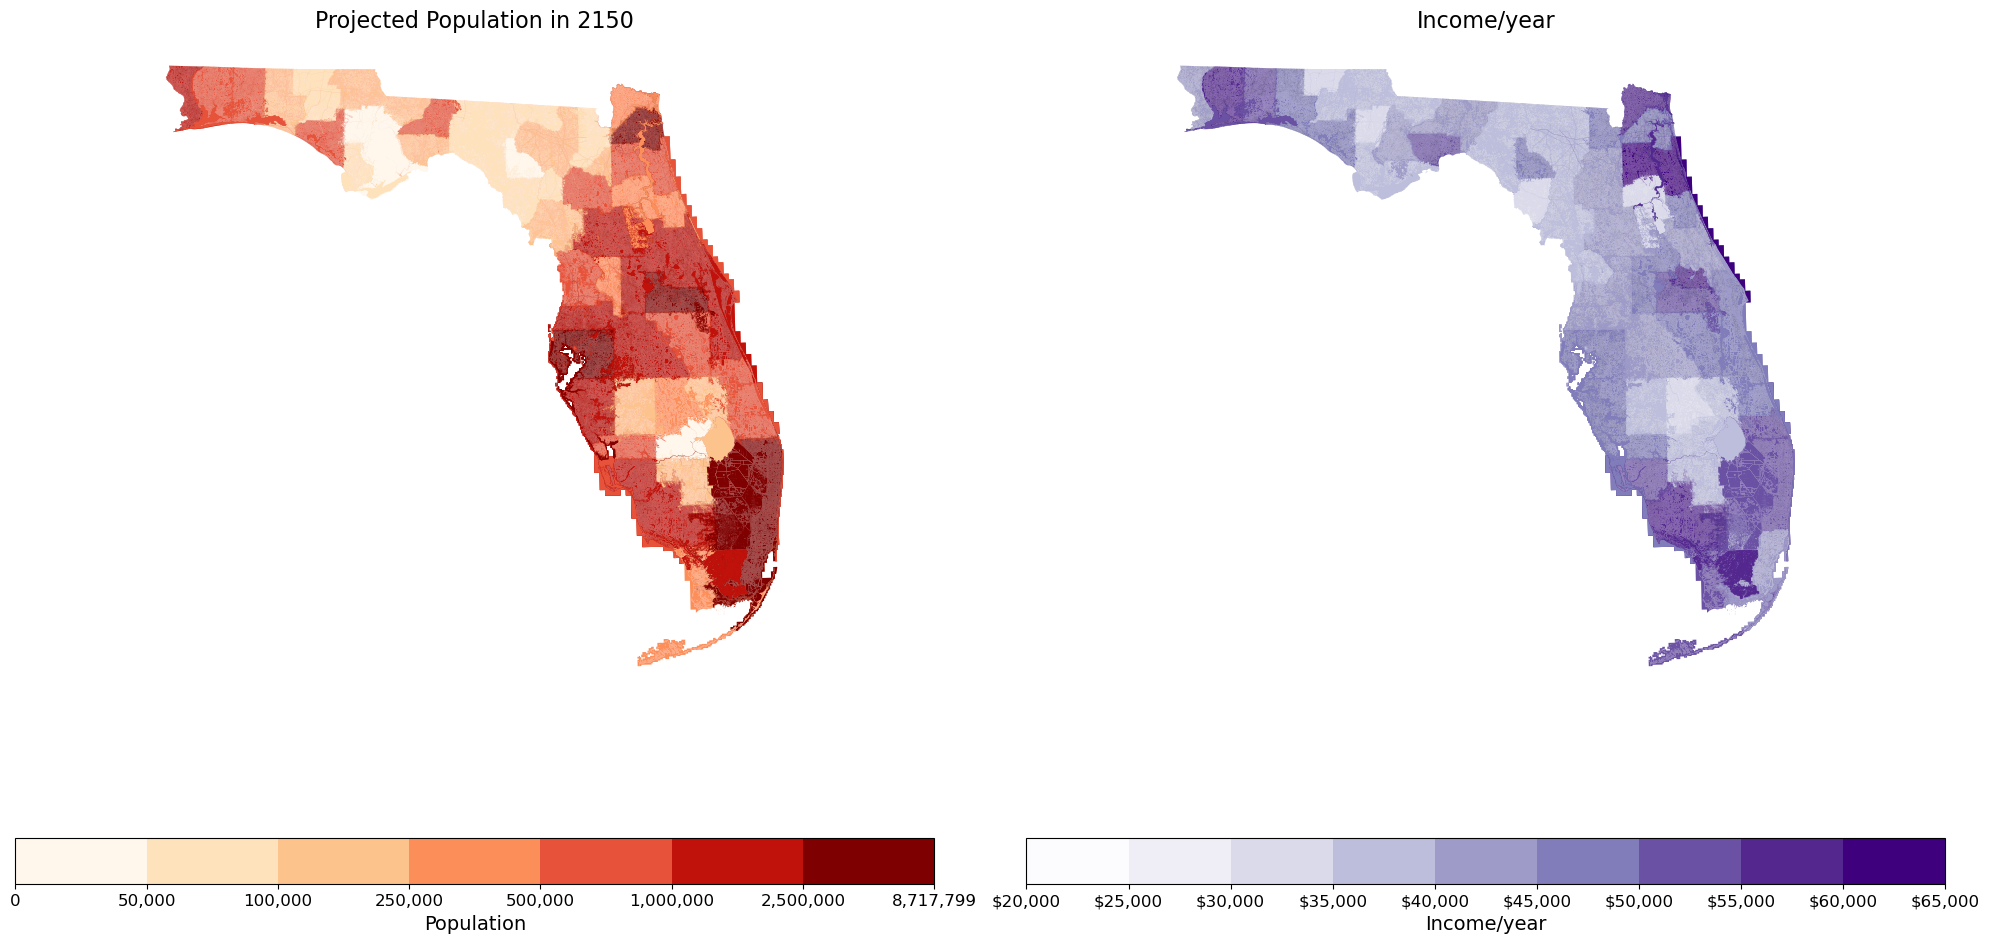

In [44]:
# Define the custom bins and their labels for the income colorbar
income_bins = [20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000]
income_bin_labels = [f"${int(b):,}" for b in income_bins]

fig, ax = plt.subplots(1, 2, figsize=(20,10))

# For Population
cmap = plt.cm.OrRd
norm = mcolors.BoundaryNorm(bins, cmap.N)
pop_plot = gdf.plot(column='POP2150', ax=ax[0], cmap=cmap, legend=False, norm=norm)
ax[0].set_title('Projected Population in 2150', fontsize=16)
ax[0].axis('off')
# Create a custom colorbar for Population
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ticks=bins, ax=ax[0], orientation='horizontal')
cbar.set_label('Population', fontsize=14)
cbar.ax.set_xticklabels(bin_labels, fontsize=12)

# For Income
income_cmap = plt.cm.Purples
income_norm = mcolors.BoundaryNorm(income_bins, income_cmap.N)
income_plot = gdf.plot(column='Income/year', ax=ax[1], cmap=income_cmap, legend=False, norm=income_norm)
ax[1].set_title('Income/year', fontsize=16)
ax[1].axis('off')
# Create a custom colorbar for Income
income_cbar = plt.colorbar(plt.cm.ScalarMappable(norm=income_norm, cmap=income_cmap), ticks=income_bins, ax=ax[1], orientation='horizontal')
income_cbar.set_label('Income/year', fontsize=14)
income_cbar.ax.set_xticklabels(income_bin_labels, fontsize=12)

plt.tight_layout()
plt.show()

# Next step is projecting income/year in 2150.

In [45]:
gdf.isna().sum()

NAME                   3047
LEVEL1_LAN                0
LEVEL1_L_1                0
POP2010                3047
AVG ELEVATION          3047
elevation_post_rise    3047
POP2150                3047
Income/year            3047
elevation_category     3047
pop_category           3047
income_category        3047
geometry                  0
dtype: int64

In [46]:
# Drop rows with missing values
gdf_cleaned = gdf.dropna()

# Verify the operation
print(gdf_cleaned.isna().sum())


NAME                   0
LEVEL1_LAN             0
LEVEL1_L_1             0
POP2010                0
AVG ELEVATION          0
elevation_post_rise    0
POP2150                0
Income/year            0
elevation_category     0
pop_category           0
income_category        0
geometry               0
dtype: int64


In [47]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1429635 entries, 0 to 1429634
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   NAME                 1426588 non-null  object  
 1   LEVEL1_LAN           1429635 non-null  int64   
 2   LEVEL1_L_1           1429635 non-null  object  
 3   POP2010              1426588 non-null  float64 
 4   AVG ELEVATION        1426588 non-null  float64 
 5   elevation_post_rise  1426588 non-null  float64 
 6   POP2150              1426588 non-null  float64 
 7   Income/year          1426588 non-null  float64 
 8   elevation_category   1426588 non-null  float64 
 9   pop_category         1426588 non-null  float64 
 10  income_category      1426588 non-null  float64 
 11  geometry             1429635 non-null  geometry
dtypes: float64(8), geometry(1), int64(1), object(2)
memory usage: 130.9+ MB


In [48]:
gdf.head()

,NAME,LEVEL1_LAN,LEVEL1_L_1,POP2010,AVG ELEVATION,elevation_post_rise,POP2150,Income/year,elevation_category,pop_category,income_category,geometry
0,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,0.0,3.0,3.0,"POLYGON ((750115.595 412370.468, 750125.324 41..."
1,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,0.0,3.0,3.0,"POLYGON ((752116.494 412629.206, 752040.467 41..."
2,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,0.0,3.0,3.0,"POLYGON ((748400.901 412660.544, 748403.552 41..."
3,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,0.0,3.0,3.0,"POLYGON ((749089.150 412759.063, 749113.236 41..."
4,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,0.0,3.0,3.0,"POLYGON ((749593.376 412700.825, 749598.792 41..."


In [49]:
gdf = gdf.drop(columns=['elevation_category', 'pop_category', 'income_category'])
# Not sure where the category columns came from, just going to drop them.

In [66]:
gdf.head()

,NAME,LEVEL1_LAN,LEVEL1_L_1,POP2010,AVG ELEVATION,elevation_post_rise,POP2150,Income/year,geometry
0,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,"POLYGON ((750115.595 412370.468, 750125.324 41..."
1,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,"POLYGON ((752116.494 412629.206, 752040.467 41..."
2,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,"POLYGON ((748400.901 412660.544, 748403.552 41..."
3,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,"POLYGON ((749089.150 412759.063, 749113.236 41..."
4,Indian River,1000,Urban and Built-Up,143385.0,8.0,4.08,507362.297202,47341.0,"POLYGON ((749593.376 412700.825, 749598.792 41..."
